In [50]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import matplotlib.pylab as pylab
import matplotlib.ticker as mtick

import csv
import numpy as np

params = {'axes.titlesize':'x-large'}
pylab.rcParams.update(params)

In [51]:
option_list = ['kaggle', 'chest', 'mnist-relu', 'mnist-sigmoid', 'cifar-10-relu', 'cifar-10-sigmoid', 'cifar-10-top3-relu', 'cifar-10-top3-sigmoid'] 

model_list = ['model #1 (Credit Card Fraud)',
              'model #2 (Chest X-ray)',
              'model #3 (MNIST ReLU)',
              'model #4 (MNIST Sigmoid)',
              'model #5 (CIFAR-10 ReLU)',
              'model #6 (CIFAR-10 Sigmoid)']

color_scheme = ['b', 'c', 'g', 'm', 'maroon', 'darkgoldenrod']

line_style_scheme = ['-', '--', '-.', ':']

use_highest_rather_than_median = True

In [52]:
def read_robustness_from_baseline(baselinefile, epsilon_index):
    # Read from baseline log
    robustness_baseline_lst = []
    num_epoch = 0
    with open(baselinefile, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        # This skips the first 2 rows of the CSV file (the first pruning starts at row 3).
        next(csvreader)
       
        for row in csvreader:
            num_epoch += 1
            # The first 1 or 2 items in each row are number of robustness instances, depends on epsilon index
            # The last item in each row is the [loss, accuracy]
            robustness_baseline_lst.append(int(row[epsilon_index]))
            # print(robustness[-1],accuracy[-1])
        num_epoch_baseline = num_epoch
    
    return robustness_baseline_lst

def read_accuracy_from_baseline(baselinefile):
    # Read from baseline log
    accuracy_baseline_lst = []
    num_epoch = 0
    with open(baselinefile, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        # This skips the first 2 rows of the CSV file (the first pruning starts at row 3).
        next(csvreader)
       
        for row in csvreader:
            num_epoch += 1
            accuracy_baseline_lst.append(float(row[-1][1:-1].split(',')[-1]))
            # print(robustness[-1],accuracy[-1])
        num_epoch_baseline = num_epoch
    
    return accuracy_baseline_lst


In [53]:
def read_robustness_from_our_stat(robustness_stat_file, num_epoch_baseline, highest=use_highest_rather_than_median):
    robustness_our_lst = []
    if highest:
        index_of_choice = 2
    else:
        index_of_choice = 3

    num_epoch = 0
    with open(robustness_stat_file, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        next(csvreader)
       
        for row in csvreader:
            robustness_our_lst.append(int(row[index_of_choice]))
            num_epoch += 1
            if num_epoch >= num_epoch_baseline:
                break
    return robustness_our_lst

def read_accuracy_from_our_stat(accuracy_stat_file, num_epoch_baseline, highest=use_highest_rather_than_median):
    accuracy_our_lst = []
    if highest:
        index_of_choice = 2
    else:
        index_of_choice = 3

    num_epoch = 0
    with open(accuracy_stat_file, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        next(csvreader)
       
        for row in csvreader:
            accuracy_our_lst.append(float(row[index_of_choice]))
            num_epoch += 1
            if num_epoch >= num_epoch_baseline:
                break
    
    return accuracy_our_lst


In [54]:
def calculate_improvement(baseline, ours):
    improvement = []
    assert len(baseline)==len(ours)
    for i in range(0, len(baseline)):
        improvement.append(ours[i] / baseline[i] - 1.0)
    return improvement

In [55]:
def plot_improvement(model_id, ax1, ax2):
    model = option_list[model_id]
    baseline_file = "logs/baseline/"+model+"-1000_tape_baseline.csv"
    
    robustness_our_stat_file_top = ""
    robustness_our_stat_file_top_2 = ""

    # For those models has two epsilon involved, add another improvement curve for robustness
    if model_id >= 2:
        robustness_baseline_lst = read_robustness_from_baseline(baseline_file,0)
        robustness_baseline_lst_2 = read_robustness_from_baseline(baseline_file,1)
        
        # For models 5 and 6, we also have top 3 assessment for robustness
        if model_id >= 4:
            if model_id == 4:
                baseline_top3_file = "logs/baseline/cifar-10-top3-relu-1000_tape_baseline.csv"
            else:
                baseline_top3_file = "logs/baseline/cifar-10-top3-sigmoid-1000_tape_baseline.csv"
                
            robustness_baseline_lst_top = read_robustness_from_baseline(baseline_top3_file,0)
            robustness_baseline_lst_top_2 = read_robustness_from_baseline(baseline_top3_file,1)

    else:
        robustness_baseline_lst = read_robustness_from_baseline(baseline_file,0)
        robustness_baseline_lst_2 = []
    accuracy_baseline_lst = read_accuracy_from_baseline(baseline_file)

    epoch_baseline = len(accuracy_baseline_lst)
    
    # For those models has two epsilon involved, add another improvement curve for robustness
    if model_id >= 2:
        robustness_our_stat_file = "logs/stat/"+model+"-robustness-e1.csv"
        robustness_our_stat_file_2 = "logs/stat/"+model+"-robustness-e2.csv"

        # For models 5 and 6, we also have top 3 assessment for robustness
        if model_id >= 4:
            if model_id == 4:
                robustness_our_stat_file_top = "logs/stat/cifar-10-top3-relu-robustness-e1.csv"
                robustness_our_stat_file_top_2 = "logs/stat/cifar-10-top3-relu-robustness-e2.csv"
            else:
                robustness_our_stat_file_top = "logs/stat/cifar-10-top3-sigmoid-robustness-e1.csv"
                robustness_our_stat_file_top_2 = "logs/stat/cifar-10-top3-sigmoid-robustness-e2.csv"

    else:
        robustness_our_stat_file = "logs/stat/"+model+"-robustness.csv"
        robustness_our_stat_file_2 = ""

    accuracy_our_stat_file = "logs/stat/"+model+"-accuracy.csv"
    
    step_per_epoch = 0.5/(epoch_baseline - 1)
    steps =  []

    for i in range(0, epoch_baseline):
        steps.append(step_per_epoch * i)

    accuracy_our_lst = read_accuracy_from_our_stat(accuracy_our_stat_file, epoch_baseline)
    improvement_accuracy = calculate_improvement(accuracy_baseline_lst, accuracy_our_lst)
    
    ax2.plot(steps, improvement_accuracy, color=color_scheme[model_id], linestyle=line_style_scheme[0] ,label=model_list[model_id])

    robustness_our_lst = read_robustness_from_our_stat(robustness_our_stat_file, epoch_baseline)
    improvement_robustness = calculate_improvement(robustness_baseline_lst, robustness_our_lst)

    ax1.plot(steps, improvement_robustness, color=color_scheme[model_id], linestyle=line_style_scheme[0] ,label=model_list[model_id])

    # For those models has two epsilon involved, add another improvement curve for robustness
    if model_id >= 2:
        robustness_our_lst_2 = read_robustness_from_our_stat(robustness_our_stat_file_2, epoch_baseline)
        improvement_robustness_2 = calculate_improvement(robustness_baseline_lst_2, robustness_our_lst_2)

        ax1.plot(steps, improvement_robustness_2, color=color_scheme[model_id], linestyle=line_style_scheme[1] ,label=model_list[model_id])
        
        # For models 5 and 6, we also have top 3 assessment for robustness
        if model_id >= 4:
            robustness_our_lst_top = read_robustness_from_our_stat(robustness_our_stat_file_top, epoch_baseline)
            robustness_our_lst_top_2 = read_robustness_from_our_stat(robustness_our_stat_file_top_2, epoch_baseline)
            improvement_robustness_top = calculate_improvement(robustness_baseline_lst_top, robustness_our_lst_top)
            improvement_robustness_top_2 = calculate_improvement(robustness_baseline_lst_top_2, robustness_our_lst_top_2)

            ax1.plot(steps, improvement_robustness_top, color=color_scheme[model_id], linestyle=line_style_scheme[2] ,label=model_list[model_id])
            ax1.plot(steps, improvement_robustness_top_2, color=color_scheme[model_id], linestyle=line_style_scheme[3] ,label=model_list[model_id])



<ipython-input-56-e470b7e898b5>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['{:,.0%}'.format(val) for val in ax1.get_xticks()])
<ipython-input-56-e470b7e898b5>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.0%}'.format(val) for val in ax1.get_yticks()])
<ipython-input-56-e470b7e898b5>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['{:,.0%}'.format(val) for val in ax1.get_xticks()])
<ipython-input-56-e470b7e898b5>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0%}'.format(val) for val in ax1.get_yticks()])


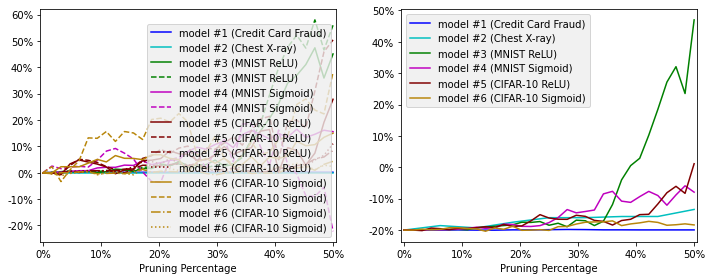

In [56]:

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
gridsize = (1, 2)
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=1)

plot_improvement(0, ax1, ax2)
plot_improvement(1, ax1, ax2)
plot_improvement(2, ax1, ax2)
plot_improvement(3, ax1, ax2)
plot_improvement(4, ax1, ax2)
plot_improvement(5, ax1, ax2)

ax1.set_xlabel('Pruning Percentage')
ax2.set_xlabel('Pruning Percentage')

# color = 'tab:blue'
ax2.set_ylabel('Accuracy', color='white', labelpad=3)  # we already handled the x-label with ax1
    
# fixing yticks with matplotlib.ticker "FixedLocator"
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_xticklabels(['{:,.0%}'.format(val) for val in ax1.get_xticks()])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_yticklabels(['{:,.0%}'.format(val) for val in ax1.get_yticks()])

ax2.xaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_xticklabels(['{:,.0%}'.format(val) for val in ax1.get_xticks()])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_yticklabels(['{:,.0%}'.format(val) for val in ax1.get_yticks()])

ax1.set_xlim([-0.005, 0.505])
ax2.set_xlim([-0.005, 0.505])

#labs = [l.get_label() for l in lns]
legend1 = ax1.legend()
legend1.get_frame().set_facecolor('#EEEEEE')
legend2 = ax2.legend()
legend2.get_frame().set_facecolor('#EEEEEE')

plt.tight_layout()

figure_filename = "save_figs/improvement.pdf"
if os.path.exists(figure_filename):
  os.remove(figure_filename)

plt.savefig(figure_filename)

plt.show()
